In [2]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['TwitterAnalysis']
collection = db['Tweets']


In [3]:
import re
from textblob import TextBlob
import pandas as pd

# Query all documents from the collection
cursor = collection.find()

# Convert documents to a list of dictionaries
data = list(cursor)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

def clean_tweet_text(tweet):
    # Remove special characters, URLs, and usernames using regular expressions
    tweet = re.sub(r'http\S+|www\S+|@[^\s]+|\W', ' ', tweet)
    # Remove extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

def analyze_sentiment(tweet):
    # Create a TextBlob object
    analysis = TextBlob(tweet)
    # Get the sentiment polarity
    polarity = analysis.sentiment.polarity
    # Classify the sentiment
    if polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Clean the tweet text and analyze sentiment for each row in the DataFrame
df['clean_text'] = df['text'].apply(clean_tweet_text)
df['sentiment'] = df['clean_text'].apply(analyze_sentiment)


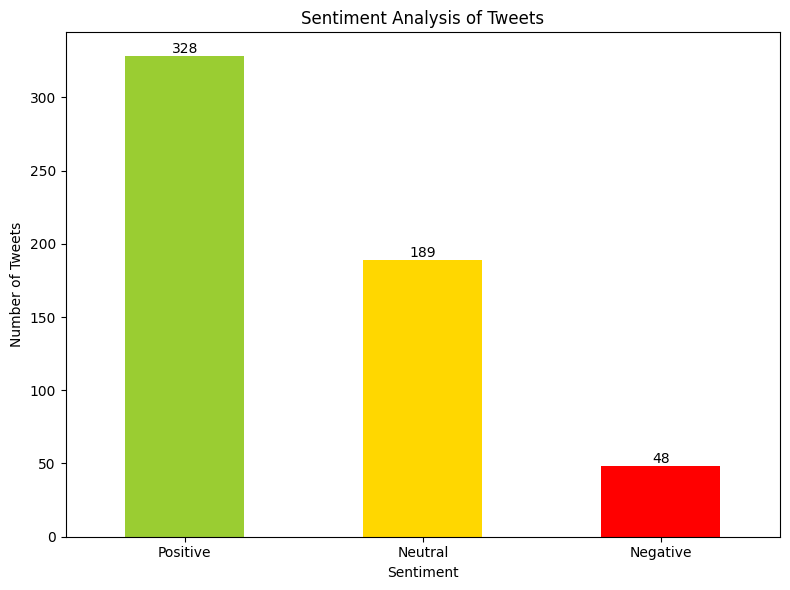

In [4]:
import matplotlib.pyplot as plt

# Group the DataFrame by sentiment and count the occurrences
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment analysis
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['yellowgreen', 'gold', 'red'])

# Add labels on top of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Add title and labels
plt.title('Sentiment Analysis of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)  # Rotate x labels if necessary

# Show plot
plt.tight_layout()
plt.show()


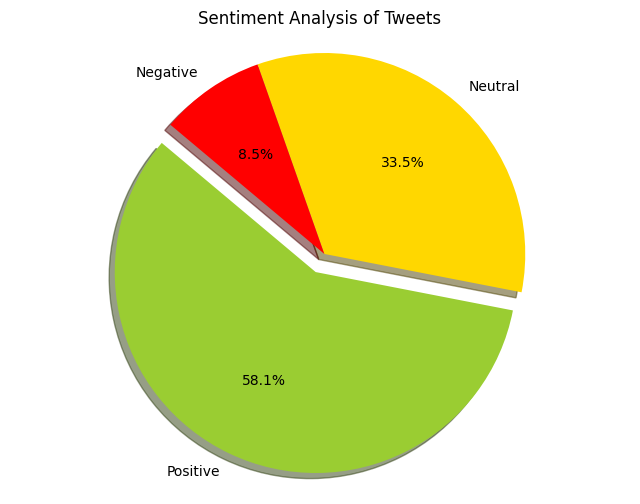

In [5]:
# Count the number of tweets for each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Get the counts for each sentiment
positive_count = sentiment_counts.get('Positive', 0)
neutral_count = sentiment_counts.get('Neutral', 0)
negative_count = sentiment_counts.get('Negative', 0)

# Plot sentiment analysis results
labels = ['Positive', 'Neutral', 'Negative']
sizes = [positive_count, neutral_count, negative_count]
colors = ['yellowgreen', 'gold', 'red']
explode = (0.1, 0, 0)  # explode 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Sentiment Analysis of Tweets')
plt.show()



In [6]:
from datetime import datetime

# Function to unify date format
def unify_date_format(date_str):
    # Parse the date string
    date_obj = datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')
    # Return the date in desired format
    return date_obj.strftime('%d/%m/%Y')

# Apply the function to unify date format
df['createdAt'] = df['createdAt'].apply(unify_date_format)

# Select the desired columns
selected_columns = ['clean_text', 'retweetCount', 'replyCount', 'likeCount', 'createdAt', 'sentiment']
selected_df = df[selected_columns]

# Convert DataFrame to dictionary
tweets_dict = selected_df.to_dict(orient='records')

collection = db['Clean_Tweets']

# Insert the tweets into MongoDB 
collection.insert_many(tweets_dict)

# Print success message
print("Tweets inserted into MongoDB successfully.")


Tweets inserted into MongoDB successfully.
